<a href="https://colab.research.google.com/github/ingridheuer/GCNN_for_GDAs/blob/main/exploration/notebooks/RSAGE_nofeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalo e importo librerias

In [1]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html


In [2]:
#Librería base de redes neuronales de torch
#Acá están las clases "base" de las que heredan todos los modelos
import torch.nn as nn

#Operaciones entre sparse matrix
from torch_sparse import matmul, SparseTensor

#Librerías específicas de GNNs: 
#PYG es la libraría general de GNNs,
#DeepSNAP tiene utilidades para el manejo de datos y grafos heterogeneos, hacer splits, negative sampling, etc.
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import HeteroConv
from deepsnap.dataset import GraphDataset
import deepsnap.hetero_gnn
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_geometric.utils import to_undirected
import torch.nn.functional as F
#from torch_geometric.data import HeteroData

#Para manejar los minibatches
from torch.utils.data import DataLoader
from deepsnap.batch import Batch

from timeit import default_timer as timer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import copy

# Modelo

In [3]:
class distmult_head(torch.nn.Module):
  def __init__(self, hetero_graph, hidden_size):
    super().__init__()
    self.R_weights = nn.ParameterDict()

    for edge_type in hetero_graph.edge_types:
      self.R_weights[edge_type] = nn.Parameter(torch.rand(hidden_size,hidden_size)*0.01)
  
  def score(self,x,edge_label_index):
    scores = {}
    for message_type in edge_label_index:
      src_type,edge_type,trg_type = message_type[0], message_type[1], message_type[2]
      rel_weights = self.R_weights[edge_type]
      nodes_left = torch.index_select(x[src_type], 0, edge_label_index[message_type][0,:].long())
      nodes_right = torch.index_select(x[trg_type], 0, edge_label_index[message_type][1,:].long())
      mid_product = nodes_right@rel_weights
      scores[message_type] = torch.sum(mid_product@torch.t(nodes_left) , dim=-1)
    return scores

In [4]:
def edgeindex_to_sparsematrix(het_graph: HeteroGraph) -> dict : 
    sparse_edge_dict = {}
    for key in het_graph.edge_index:
        temp_edge_index = het_graph.edge_index[key]
        from_type = key[0]
        to_type = key[2]
        adj = SparseTensor(row=temp_edge_index[0], col=temp_edge_index[1], sparse_sizes=(het_graph.num_nodes(from_type), het_graph.num_nodes(to_type)))
        sparse_edge_dict[key] = adj.t()
    return sparse_edge_dict

debugging = False

def my_debug(arg):
    if debugging:
        print(arg)


class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super().__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels
        self.lin_dst = nn.Linear(in_channels_dst, out_channels)
        self.lin_src = nn.Linear(in_channels_src, out_channels)
        self.lin_update = nn.Linear(2*out_channels, out_channels)

    def forward(
            self,
            node_feature_src,
            node_feature_dst,
            edge_index,
            size=None):

        out = self.propagate(edge_index, size, node_feature_src=node_feature_src, node_feature_dst=node_feature_dst)
        return out

    def message_and_aggregate(self, edge_index, node_feature_src):
        out = matmul(edge_index, node_feature_src, reduce=self.aggr)
        return out

    def update(self, aggr_out, node_feature_dst):
        dst_msg = self.lin_dst(node_feature_dst)
        src_msg = self.lin_src(aggr_out)
        full_msg = torch.concat((dst_msg, src_msg), dim=-1)
        out = self.lin_update(full_msg)
        return out


class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super().__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

    def reset_parameters(self):
        super().reset_parameters()

    def forward(self, node_features, edge_indices):
        message_type_emb = {}

        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (self.convs[message_key](node_feature_src,node_feature_dst,edge_index))

        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}

        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb

    def aggregate(self, xs):
        return torch.mean(torch.stack(xs, dim=-1), dim=-1)

def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    convs = {}

    msg_types = hetero_graph.message_types
    for key in msg_types:
        if first_layer:
            dst_feature_dim = hetero_graph.num_node_features(key[2])
            src_feature_dim = hetero_graph.num_node_features(key[0])
            convs[key] = conv(src_feature_dim, dst_feature_dim, hidden_size)
        else:
            convs[key] = conv(hidden_size, hidden_size, hidden_size)

    return convs


class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, head, pred_mode, args, aggr="mean"):
        super().__init__()

        self.aggr = aggr
        self.head = head
        self.pred_mode = pred_mode
        self.hidden_size = args['hidden_size']
        self.bns1 = torch.nn.ModuleDict()
        self.bns2 = torch.nn.ModuleDict()
        self.relus1 = torch.nn.ModuleDict()
        self.relus2 = torch.nn.ModuleDict()
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
        if head=="dismult":
          self.distmult_head = distmult_head(hetero_graph,self.hidden_size)

        convs1 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True)
        convs2 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=False)
        self.convs1 = HeteroGNNWrapperConv(convs1, args, aggr=self.aggr)
        self.convs2 = HeteroGNNWrapperConv(convs2, args, aggr=self.aggr)
        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size)
            self.bns2[node_type] = torch.nn.BatchNorm1d(self.hidden_size)
            self.relus1[node_type] = torch.nn.LeakyReLU()
            self.relus2[node_type] = torch.nn.LeakyReLU()

    def forward(self, graph):
        x, edge_label_index = graph.node_feature, graph.edge_label_index
        adj = edgeindex_to_sparsematrix(graph)
        x = self.convs1(x, edge_indices=adj)
        x = deepsnap.hetero_gnn.forward_op(x, self.bns1)
        x = deepsnap.hetero_gnn.forward_op(x, self.relus1)
        x = self.convs2(x, edge_indices=adj)
        x = deepsnap.hetero_gnn.forward_op(x, self.bns2)


        if self.head == "dotprod":
          pred = {}
          if self.pred_mode == "all":
            for message_type in edge_label_index:
                src_type = message_type[0]
                trg_type = message_type[2]
                nodes_first = torch.index_select(x[src_type], 0, edge_label_index[message_type][0,:].long())
                nodes_second = torch.index_select(x[trg_type], 0, edge_label_index[message_type][1,:].long())
                pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
          elif self.pred_mode == "gda_only":
            keys = [('gene/protein', 'GDA', 'disease'), ('disease', 'GDA', 'gene/protein')]
            for message_type in keys:
              src_type = message_type[0]
              trg_type = message_type[2]
              nodes_first = torch.index_select(x[src_type], 0, edge_label_index[message_type][0,:].long())
              nodes_second = torch.index_select(x[trg_type], 0, edge_label_index[message_type][1,:].long())
              pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
          return pred
        elif self.head == "distmult":
          return self.distmult_head.score(x,edge_label_index)
          
    def loss(self, pred, y):
        loss = 0
        sets = torch.tensor(len(pred.keys()))
        for key in pred:
            p = pred[key]
            loss += self.loss_fn(p, y[key].type(pred[key].dtype))
        return loss

# Preprocesamiento del dataset

In [5]:
node_data = pd.read_csv("/content/graph_node_table.csv", index_col=0)
edge_data = pd.read_csv("/content/graph_edge_table.csv",index_col=0).rename(columns={"relation":"edge_type"})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
display(node_data.head())
display(edge_data.head())

,node_idx,node_id,node_type,node_name,node_source
1,1,1,gene/protein,A1BG,disgenet
2,2,2,gene/protein,A2M,disgenet
3,3,9,gene/protein,NAT1,disgenet
4,4,10,gene/protein,NAT2,disgenet
5,5,12,gene/protein,SERPINA3,disgenet


,edge_idx,a_idx,b_idx,a_id,b_id,edge_type,a_type,b_type,source,source_idx
1,1,1839,14989,3440,C0000737,GDA,gene/protein,disease,disgenet,26518
2,2,2389,15912,4547,C0000744,GDA,gene/protein,disease,disgenet,34865
3,3,5236,10506,10683,C0000768,GDA,gene/protein,disease,disgenet,63589
4,4,724,10506,1295,C0000768,GDA,gene/protein,disease,disgenet,11121
5,5,741,10506,1317,C0000768,GDA,gene/protein,disease,disgenet,11360


In [6]:
def init_node_features(G, mode, size):
  if mode == "ones":
    feature = torch.ones(size)
    nx.set_node_attributes(G, feature, 'node_feature')
  elif mode == "random":
    feature_dict = {}
    for node in list(G.nodes()):
      feature_dict[node] = torch.rand(size)
    nx.set_node_attributes(G,feature_dict,'node_feature')

In [14]:
D = nx.from_pandas_edgelist(edge_data,source="a_idx",target="b_idx", edge_attr="edge_type")
nx.set_node_attributes(D,pd.Series(node_data.node_type, index=node_data.node_idx).to_dict(),"node_type")
nx.set_node_attributes(D,pd.Series(node_data.node_name, index=node_data.node_idx).to_dict(),"node_name")

#G = nx.to_undirected(D)
G = D.to_directed()
init_node_features(G,"random",5)

node_id = 5
print(f"Node {node_id} has properties:", G.nodes(data=True)[node_id])
edges = list(G.edges())
edge_idx = 123456
n1 = edges[edge_idx][0]
n2 = edges[edge_idx][1]
edge = list(G.edges(data=True))[edge_idx]
print(f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
print(f"Node {n1} has properties:", G.nodes(data=True)[n1])
print(f"Node {n2} has properties:", G.nodes(data=True)[n2])

Node 5 has properties: {'node_type': 'gene/protein', 'node_name': 'SERPINA3', 'node_feature': tensor([0.5785, 0.3834, 0.8792, 0.7223, 0.9074])}
Edge (2725, 21665) has properties: {'edge_type': 'PPI'}
Node 2725 has properties: {'node_type': 'gene/protein', 'node_name': 'PDPK1', 'node_feature': tensor([0.1449, 0.7143, 0.6988, 0.3077, 0.7945])}
Node 21665 has properties: {'node_type': 'gene/protein', 'node_name': 'CDC37_HUMAN', 'node_feature': tensor([0.2978, 0.4468, 0.4633, 0.0280, 0.9838])}


In [18]:
init_node_features(G,"random",5)
print(G.nodes(data=True)[1])

{'node_type': 'gene/protein', 'node_name': 'A1BG', 'node_feature': tensor([0.0525, 0.9543, 0.1926, 0.4566, 0.9332])}


In [21]:
Hete = HeteroGraph(G)
print(Hete.edge_types)
print(Hete.message_types)
print(Hete.node_types)
print(Hete.num_nodes())
print(Hete.num_edges())

['parent_child_mondo', 'PPI', 'GDA', 'forms_complex']
[('gene/protein', 'GDA', 'disease'), ('gene/protein', 'PPI', 'gene/protein'), ('disease', 'GDA', 'gene/protein'), ('disease', 'parent_child_mondo', 'disease'), ('gene/protein', 'forms_complex', 'protein_complex'), ('protein_complex', 'forms_complex', 'gene/protein')]
['gene/protein', 'disease', 'protein_complex']
{'gene/protein': 16672, 'disease': 18548, 'protein_complex': 422}
{('gene/protein', 'GDA', 'disease'): 84038, ('gene/protein', 'PPI', 'gene/protein'): 294970, ('disease', 'GDA', 'gene/protein'): 84038, ('disease', 'parent_child_mondo', 'disease'): 30419, ('gene/protein', 'forms_complex', 'protein_complex'): 1888, ('protein_complex', 'forms_complex', 'gene/protein'): 1888}


# Funciones de entrenamiento y evaluación

In [7]:
def train(model, optimizer, graph, printb):
    model.train()
    optimizer.zero_grad()
    preds = model(graph)
    loss = model.loss(preds, graph.edge_label)
    loss.backward()
    optimizer.step()
    acc = 0
    num = 0
    for key,pred in preds.items():
      logits = torch.sigmoid(pred)
      pred_label = torch.round(logits)
      acc += (pred_label == graph.edge_label[key]).sum().item()
      num += pred_label.shape[0]
    accuracy = acc/num
    if printb:
        print(loss.item())
    return loss.item(), accuracy


# Test function
def test(model, splits_dict, args):
    model.eval()
    accs = {}
    for mode, dataset in splits_dict.items():
        acc = 0
        num = 0
        pred = model(dataset)
        for key in pred:
            p = torch.sigmoid(pred[key]).cpu().detach()
            pred_label = np.zeros_like(p, dtype=np.int64)
            pred_label[np.where(p > 0.5)[0]] = 1
            pred_label[np.where(p <= 0.5)[0]] = 0
            acc += np.sum(pred_label == dataset.edge_label[key].cpu().numpy())
            num += len(pred_label)
        accs[mode] = acc / num
    return accs

def test2(model,validation_set,global_accuracy=True):
  model.eval()
  if global_accuracy:
    acc = 0
    num = 0
    with torch.no_grad():
      preds = model(validation_set)
      for key,pred in preds.items():
        logits = torch.sigmoid(pred)
        pred_label = torch.round(logits)
        acc += (pred_label == validation_set.edge_label[key]).sum().item()
        num += pred_label.shape[0]
    accuracy = round(acc/num,3)
    return accuracy
  else:
    type_accuracy = {}
    with torch.no_grad():
      preds = model(validation_set)
      for key,pred in preds.items():
        logits = torch.sigmoid(pred)
        pred_label = torch.round(logits)
        acc = (pred_label == validation_set.edge_label[key]).sum().item()
        num = pred_label.shape[0]
        type_accuracy[key] = round(acc/num,3)
    return type_accuracy

def hits_at_k(model,dataset,k,return_indices=False) -> dict:
  hits = {}
  with torch.no_grad():
    preds = model(dataset)
    for key,pred in preds.items():
        #ordeno los puntajes de mayor a menor
        pred, indices = torch.sort(pred, descending=True)

        #corto el ranking en 0.5
        pred = pred[pred>0.5]

        #me quedo solo con los k mayor punteados
        if pred.shape[0]>k:
          pred, indices = pred[:k].to(args["device"]), indices[:k].to(args["device"])
        else:
          print(f"Top {k} scores below classification threshold 0.5, returning top {pred.shape[0]}")

        #busco que label tenían esas k preds
        labels = torch.index_select(dataset.edge_label[key],-1,indices)

        #cuento cuantas veces predije uno positivo en el top k
        if return_indices:
          #devuelvo los indices por si quiero ir a buscar los enlaces al grafo
          hits[key] = {"hits":labels.sum().item(),"indices":indices}
        else:
          #si solo quiero contar hits no devuelvo indices
          hits[key] = {"hits":labels.sum().item()}

  return hits

# Entrenamiento

In [24]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 32,
    'weight_decay': 1e-5,
    'lr': 0.001,
}
task = 'link_pred'
train_mode = "disjoint"

dataset = GraphDataset([Hete], task=task, edge_train_mode=train_mode, resample_negatives=True)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
# splits = {"train":dataset_val[0].to(args["device"])}
splits = {"train":dataset_train[0].to(args["device"]), "val":dataset_val[0].to(args["device"]), "test":dataset_test[0].to(args["device"])}

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

In [ ]:
print(splits)

{'train': HeteroGraph(G=[], edge_index=[], edge_label=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[159115], edge_type=[], negative_label_val=[1], node_feature=[], node_label_index=[], node_name=[], node_to_graph_mapping=[], node_to_tensor_mapping=[35642], node_type=[]), 'val': HeteroGraph(G=[], edge_index=[], edge_label=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[198895], edge_type=[], negative_label_val=[1], node_feature=[], node_label_index=[], node_name=[], node_to_graph_mapping=[], node_to_tensor_mapping=[35642], node_type=[]), 'test': HeteroGraph(G=[], edge_index=[], edge_label=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[348065], edge_type=[], negative_label_val=[1], node_feature=[], node_label_index=[], node_name=[], node_to_graph_mapping=[], node_to_tensor_mapping=[35642], node_type=[])}


In [22]:
model = HeteroGNN(Hete,"dotprod", "all", args, aggr="mean",).to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

16.71272087097168
7.915263652801514
6.261965274810791
5.345649719238281
4.713099956512451
4.249425411224365
3.8882579803466797
3.6011571884155273
3.360252857208252
3.153157949447632


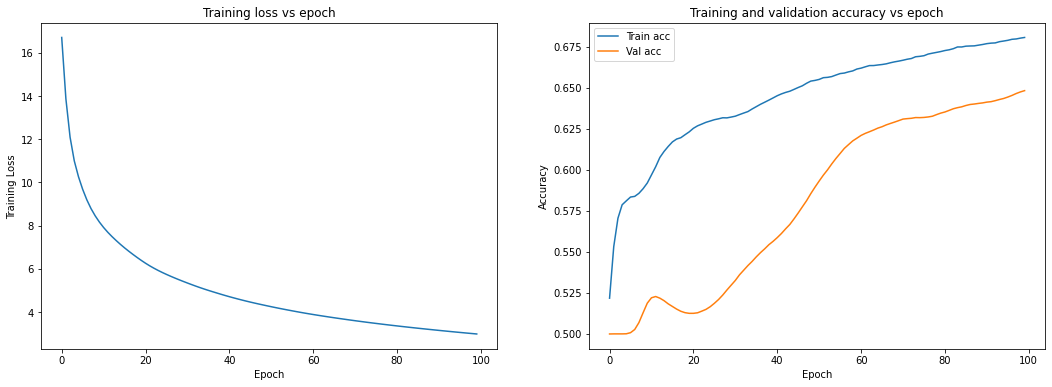

In [ ]:
loss_plot = []
train_acc = []
val_acc = []
epochs = 100
for epoch in range(epochs):
    if epoch%10 == 0:
       loss,t_acc = train(model,optimizer,splits["train"],printb=True)
       v_acc = test2(model,splits["val"])
    else:
        loss,t_acc = train(model,optimizer,splits["train"],printb=False)
        v_acc = test2(model,splits["val"])
    loss_plot.append(loss)
    train_acc.append(t_acc)
    val_acc.append(v_acc)

fig,axs = plt.subplots(1, 2, figsize=(18,6))
axs[0].plot(np.arange(epochs),loss_plot)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Training Loss")
axs[0].set_title("Training loss vs epoch")

axs[1].plot(np.arange(epochs),train_acc, label="Train acc")
axs[1].plot(np.arange(epochs),val_acc, label="Val acc")
axs[1].legend()
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training and validation accuracy vs epoch")

plt.show()

In [ ]:
test(model,splits,args)

{'test': 0.6616010618330026,
 'train': 0.6675716440422322,
 'val': 0.6481799289401354}

# Optimization

In [8]:
D = nx.from_pandas_edgelist(edge_data,source="a_idx",target="b_idx", edge_attr="edge_type")
nx.set_node_attributes(D,pd.Series(node_data.node_type, index=node_data.node_idx).to_dict(),"node_type")
nx.set_node_attributes(D,pd.Series(node_data.node_name, index=node_data.node_idx).to_dict(),"node_name")

G = D.to_directed()

In [9]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 32,
    'weight_decay': 1e-5,
    'lr': 0.001,
    'epochs':100,
    'k_hits':[5,10,20,50]
}

In [31]:
def opt_iteration(G,edge_train_mode,supervision_mode,feature_length,init_mode,args):
  """
  graph: networkx graph object
  edge_train_mode: "disjoint" or "all", supervision_mode: "all" or "gda_only", feature_length: int,
  init_mode:"random" or "ones"
  args: arguments to be shared by all iterations
  """
  results = {}
  epochs = args["epochs"]
  hits_range = args["k_hits"]
  init_node_features(G,init_mode,feature_length)
  Hete = HeteroGraph(G)

  dataset = GraphDataset([Hete], task="link_pred", edge_train_mode=edge_train_mode, resample_negatives=True)
  dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
  splits = {"train":dataset_train[0].to(args["device"]), "val":dataset_val[0].to(args["device"]), "test":dataset_test[0].to(args["device"])}

  model = HeteroGNN(Hete,"dotprod", supervision_mode, args, aggr="mean",).to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  loss_plot = []
  train_acc = []
  val_acc = []
  for epoch in range(epochs):
    if epoch%10 == 0:
       loss,t_acc = train(model,optimizer,splits["train"],printb=True)
       v_acc = test2(model,splits["val"])
    else:
        loss,t_acc = train(model,optimizer,splits["train"],printb=False)
        v_acc = test2(model,splits["val"])
    loss_plot.append(loss)
    train_acc.append(t_acc)
    val_acc.append(v_acc)

  final_acc_train = test2(model,splits["train"])
  final_acc_val = test2(model,splits["val"])
  results["Train acc"] = final_acc_train
  results["Validation acc"] = final_acc_val

  hit_dict = {}
  for k in hits_range:
    hits = hits_at_k(model,splits["val"],k)
    hit_dict[k] = hits
  
  results["Hits @ k"] = hit_dict
  edgetype_acc = test2(model,splits["val"],global_accuracy=False)
  results["Type Accuracy"] = edgetype_acc

  fig,axs = plt.subplots(1, 2, figsize=(18,6))
  fig.suptitle(f"Dimensión de feature:{feature_length}, modo de supervisión: {supervision_mode}", fontsize=16)
  axs[0].plot(np.arange(epochs),loss_plot)
  axs[0].set_xlabel("Epoch",fontsize=14)
  axs[0].set_ylabel("Training Loss",fontsize=14)
  axs[0].set_title("Training loss vs epoch", fontsize=16)

  axs[1].plot(np.arange(epochs),train_acc, label="Train acc")
  axs[1].plot(np.arange(epochs),val_acc, label="Val acc")
  axs[1].legend()
  axs[1].set_xlabel("Epoch",fontsize=14)
  axs[1].set_ylabel("Accuracy (Global)",fontsize=14)
  axs[1].set_title("Training, validation accuracy vs epoch", fontsize=16)

  #{model name}_{feature_mode}_{feature length}_{supervision mode}
  plt.savefig(f"/content/figures/rsage_{init_mode}_{feature_length}_{supervision_mode}.png")
  plt.show()
  
  torch.cuda.empty_cache()
  return results

In [18]:
torch.cuda.empty_cache()

In [11]:
import pickle

def save_results(result_dict,filename):
    with open(filename +'.pickle', 'wb') as f:
        pickle.dump(result_dict, f, pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

16.172988891601562
8.215801239013672
6.509251117706299
5.5120625495910645
4.817985534667969
4.325253963470459
3.981320381164551
3.7205944061279297
3.5111536979675293
3.3319530487060547


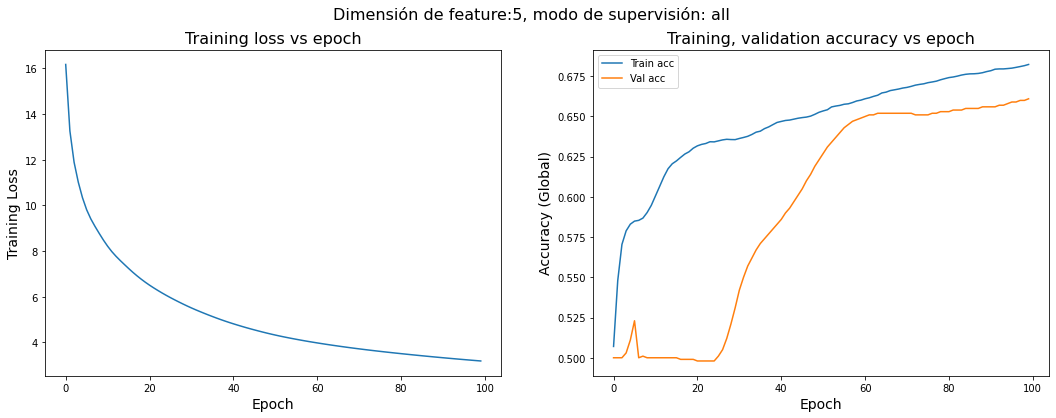

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

15.364136695861816
7.479477405548096
5.843386173248291
4.9296488761901855
4.308120250701904
3.86385178565979
3.5275380611419678
3.263774871826172
3.058497428894043
2.8954222202301025


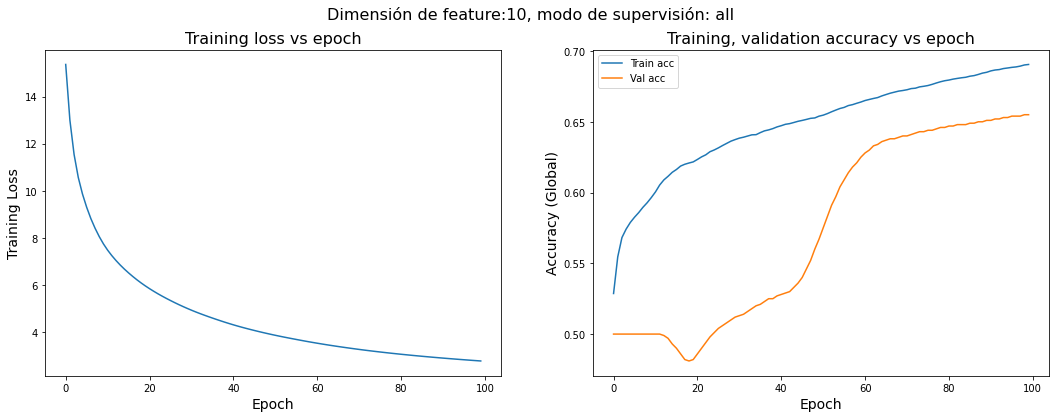

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

16.00372314453125
7.0456318855285645
5.336193561553955
4.3783369064331055
3.7651450634002686
3.3263771533966064
3.002277374267578
2.755042314529419
2.562025308609009
2.404369831085205


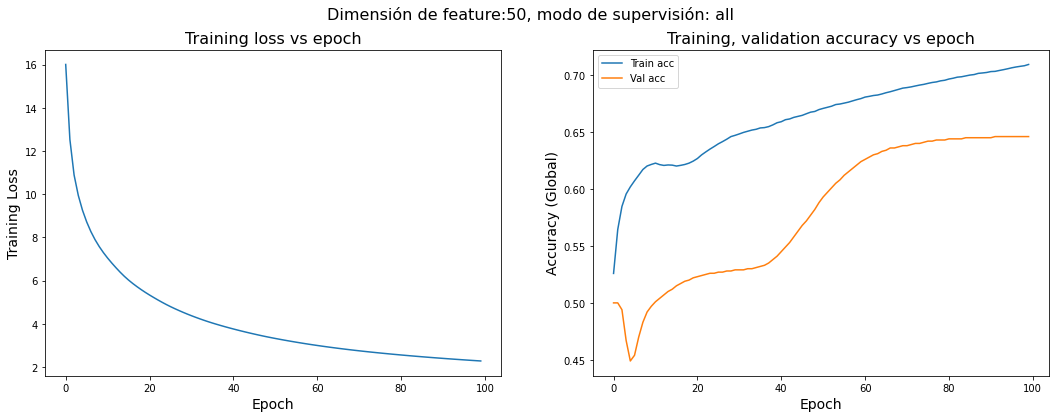

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

14.967775344848633
6.305689811706543
4.638894081115723
3.6931464672088623
3.0950818061828613
2.6918656826019287
2.403290271759033
2.188094139099121
2.0204381942749023
1.883575677871704


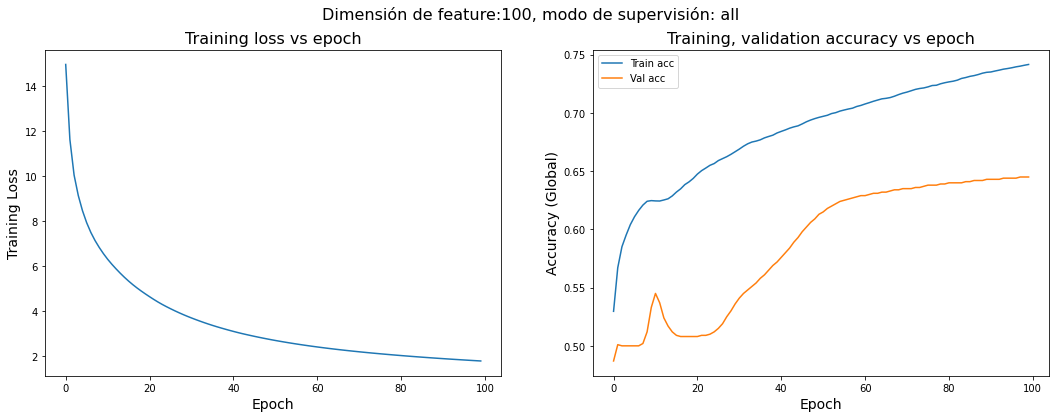

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

14.942850112915039
4.889805793762207
3.103180170059204
2.290138006210327
1.8264886140823364
1.525613784790039
1.3056349754333496
1.1356879472732544
1.0022956132888794
0.8953744173049927


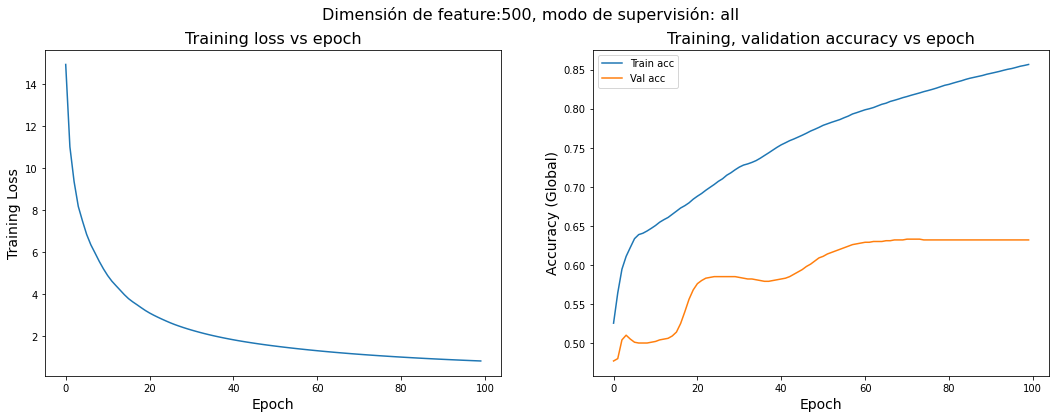

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

4.769413948059082
1.684878945350647
1.2211649417877197
1.068368673324585
1.010420799255371
0.9816036224365234
0.9635140895843506
0.9497640132904053
0.9376819133758545
0.9261474609375


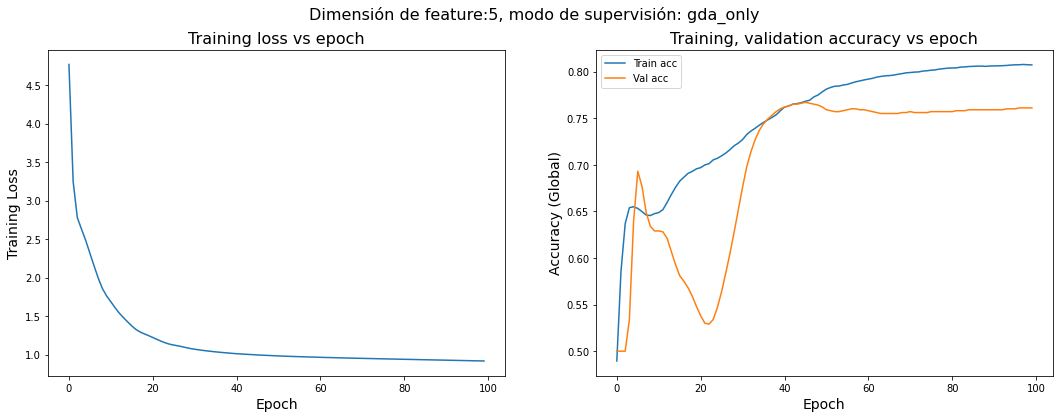

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

3.8390941619873047
1.452214002609253
1.086396336555481
0.9850287437438965
0.946526050567627
0.9227994680404663
0.903639554977417
0.8860706686973572
0.8687330484390259
0.8508687019348145


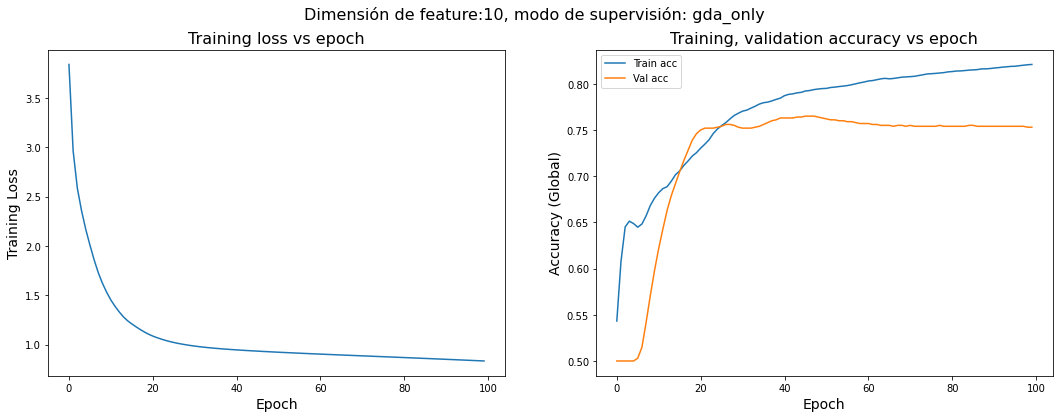

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

4.465214729309082
1.572558879852295
1.1032941341400146
0.9943276643753052
0.9474979639053345
0.9132367372512817
0.883356511592865
0.8559935092926025
0.8282793760299683
0.7992483973503113


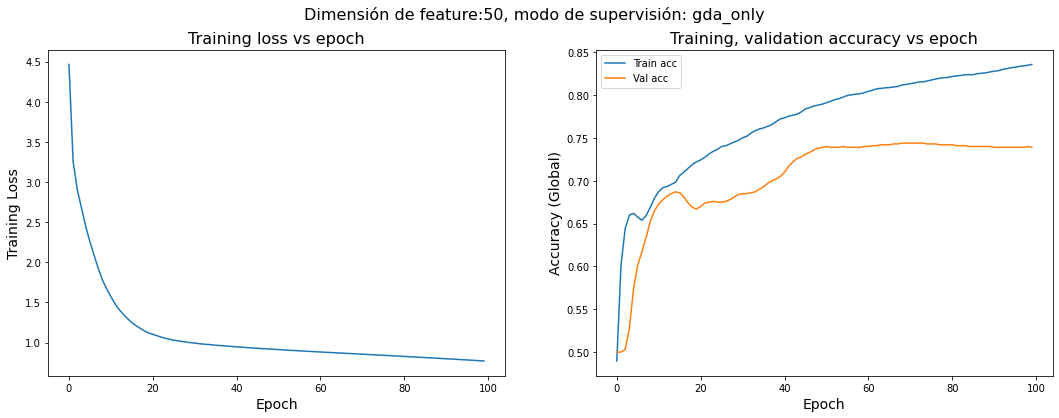

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

4.154169082641602
1.449333667755127
1.0360260009765625
0.9344754219055176
0.8800435662269592
0.8338754177093506
0.7876320481300354
0.7390525341033936
0.6878459453582764
0.6342679262161255


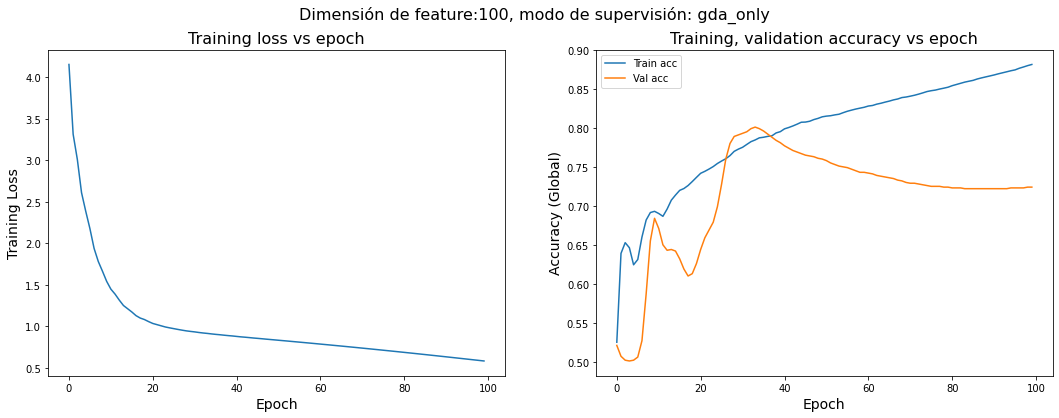

/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  col[message_type] = perm[message_type] // num_nodes[head_type]
/usr/local/lib/python3.7/dist-packages/deepsnap/hetero_graph.py:3138: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row[message_type] = perm[message_type] //

4.629812240600586
1.0955054759979248
0.9219763875007629
0.8302375674247742
0.7211004495620728
0.5996981859207153
0.4667186439037323
0.33554521203041077
0.2212066799402237
0.13754108548164368


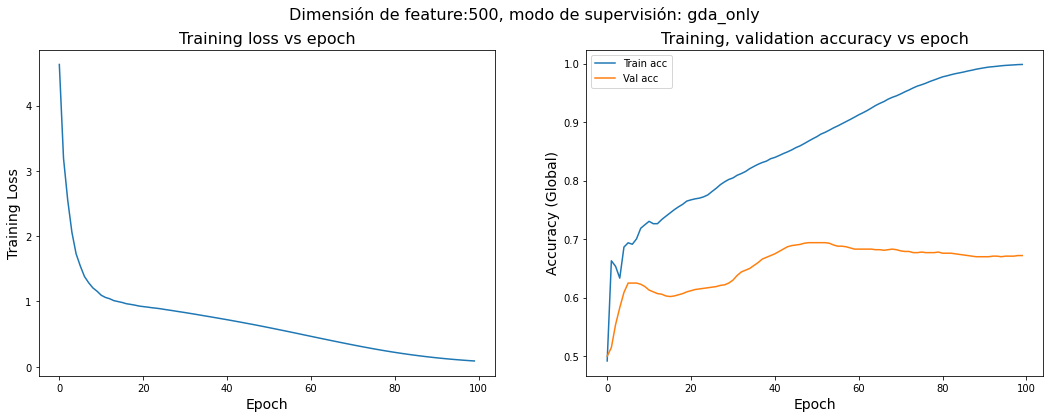

In [32]:
all_results = {}
supervision = ["all","gda_only"]
feature_len = [5,10,50,100,500]
for sup in supervision:
  for flen in feature_len:
    result = opt_iteration(G,"disjoint",sup,flen,"random",args)
    all_results[(sup,flen)] = result

save_results(all_results,"/content/results_5_7")

In [21]:
save_results(all_results,"/content/results_5_7")

In [33]:
with open('results_5_7.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [34]:
b

{('all',
  5): {'Hits @ k': {5: {('disease', 'GDA', 'gene/protein'): {'hits': 3},
    ('disease', 'parent_child_mondo', 'disease'): {'hits': 2},
    ('gene/protein', 'GDA', 'disease'): {'hits': 3},
    ('gene/protein', 'PPI', 'gene/protein'): {'hits': 5},
    ('gene/protein', 'forms_complex', 'protein_complex'): {'hits': 5},
    ('protein_complex', 'forms_complex', 'gene/protein'): {'hits': 3}},
   10: {('disease', 'GDA', 'gene/protein'): {'hits': 7},
    ('disease', 'parent_child_mondo', 'disease'): {'hits': 2},
    ('gene/protein', 'GDA', 'disease'): {'hits': 7},
    ('gene/protein', 'PPI', 'gene/protein'): {'hits': 10},
    ('gene/protein', 'forms_complex', 'protein_complex'): {'hits': 10},
    ('protein_complex', 'forms_complex', 'gene/protein'): {'hits': 7}},
   20: {('disease', 'GDA', 'gene/protein'): {'hits': 12},
    ('disease', 'parent_child_mondo', 'disease'): {'hits': 4},
    ('gene/protein', 'GDA', 'disease'): {'hits': 15},
    ('gene/protein', 'PPI', 'gene/protein'): {'hit

# aver

In [ ]:
hits = hits_at_k(model,splits["val"],5)

In [ ]:
splits["val"].edge_label_index[('disease', 'GDA', 'gene/protein')]

tensor([[  348, 10391,  2106,  ..., 18397, 14639,  2677],
        [ 1054,  1576,  4580,  ...,  2412,  3641,  7259]], device='cuda:0')

In [ ]:
hits

{('disease', 'GDA', 'gene/protein'): {'hits': 2,
  'indices': tensor([21902, 39287, 47204, 49942,  7431], device='cuda:0')},
 ('disease', 'parent_child_mondo', 'disease'): {'hits': 1,
  'indices': tensor([17737, 14405,  7729, 15404, 12771], device='cuda:0')},
 ('gene/protein', 'GDA', 'disease'): {'hits': 4,
  'indices': tensor([14414, 23456, 44151, 19757, 24928], device='cuda:0')},
 ('gene/protein', 'PPI', 'gene/protein'): {'hits': 5,
  'indices': tensor([ 3178, 15743, 32204, 50875, 54695], device='cuda:0')},
 ('gene/protein', 'forms_complex', 'protein_complex'): {'hits': 5,
  'indices': tensor([535,  63, 407, 459, 470], device='cuda:0')},
 ('protein_complex', 'forms_complex', 'gene/protein'): {'hits': 5,
  'indices': tensor([380, 211,  80, 139,   1], device='cuda:0')}}

In [ ]:
index = torch.tensor([1,2]).to(args["device"])
torch.index_select(splits["val"].edge_label_index[('disease', 'GDA', 'gene/protein')],-1,index)

tensor([[10391,  2106],
        [ 1576,  4580]], device='cuda:0')

In [ ]:
def tensor_to_edgelist(tensor):
  "Toma un edge_index de shape (2,num_edges) y devuelve una lista de tuplas"
  sources = tensor[0,:].tolist()
  targets = tensor[1,:].tolist()
  edgelist = list(zip(sources,targets))
  return edgelist

In [ ]:
for edge in predicted_edges:
  #(f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
  print(f"Node {edge[0]} has properties:", G.nodes(data=True)[edge[0]])
  print(f"Node {edge[1]} has properties:", G.nodes(data=True)[edge[1]])

Node 10391 has properties: {'node_type': 'disease', 'node_name': 'Severe Sepsis', 'node_feature': tensor([0.6661, 0.9857, 0.0499, 0.9368, 0.6643])}
Node 1576 has properties: {'node_type': 'gene/protein', 'node_name': 'GSTA1', 'node_feature': tensor([0.3824, 0.2077, 0.0681, 0.4181, 0.7049])}
Node 2106 has properties: {'node_type': 'gene/protein', 'node_name': 'STMN1', 'node_feature': tensor([0.1132, 0.1813, 0.9460, 0.9047, 0.0837])}
Node 4580 has properties: {'node_type': 'gene/protein', 'node_name': 'DHRS3', 'node_feature': tensor([0.3305, 0.3798, 0.7926, 0.7532, 0.7714])}


In [ ]:
predicted_index = hits[('disease', 'GDA', 'gene/protein')]["indices"]
predicted_edges = torch.index_select(splits["val"].edge_label_index[('disease', 'GDA', 'gene/protein')],-1,predicted_index)
edgelist = tensor_to_edgelist(predicted_edges)
for edge in edgelist:
  #(f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
  print(f"Node {edge[0]} has properties:", G.nodes(data=True)[edge[0]])
  print(f"Node {edge[1]} has properties:", G.nodes(data=True)[edge[1]])

Node 1225 has properties: {'node_type': 'gene/protein', 'node_name': 'FBLN1', 'node_feature': tensor([0.4827, 0.4690, 0.9012, 0.5607, 0.0912])}
Node 433 has properties: {'node_type': 'gene/protein', 'node_name': 'CACNB1', 'node_feature': tensor([0.8141, 0.4575, 0.5840, 0.0879, 0.0272])}
Node 9196 has properties: {'node_type': 'gene/protein', 'node_name': 'UBAP1L', 'node_feature': tensor([0.0619, 0.8342, 0.5504, 0.5447, 0.1235])}
Node 12114 has properties: {'node_type': 'disease', 'node_name': 'Trisomy 21, Mitotic Nondisjunction', 'node_feature': tensor([0.1618, 0.7546, 0.9777, 0.7863, 0.2798])}
Node 15809 has properties: {'node_type': 'disease', 'node_name': 'Malignant Bone Neoplasm', 'node_feature': tensor([0.7694, 0.6456, 0.0044, 0.1633, 0.2523])}
Node 13346 has properties: {'node_type': 'disease', 'node_name': 'Obesity, Hyperphagia, and Developmental Delay', 'node_feature': tensor([0.0554, 0.5274, 0.6205, 0.0555, 0.7730])}
Node 839 has properties: {'node_type': 'gene/protein', 'node

In [ ]:
edgelist

[(1225, 433), (9196, 12114), (15809, 13346), (839, 11129), (431, 291)]